In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
# 필요 패키지 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# #코랩에서 한글지원
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

# 1. Data Extract - SQL

## 1-1. JOIN

---
> 1-1. 5개의 테이블(order, customer, course, refund, user)을 하나의 테이블로 조인하는 쿼리를 작성

```
- 각 테이블 형태 및 key값 확인
- order, customer, course, refund, user
```

키 값 ⬇

|order|customer|user|refund|course|
|:---|:---|:---|:---|:---|
|customer_id|id|-|-|-|
|-|user_id|id|user_id|-|
|-|-|-|course_id|id|

In [ ]:
import sqlite3

# pandas 라이브러리를 사용해 csv -> sqlite 데이터베이스 변형
con = sqlite3.connect('data.db')

# 파일 읽기
order = pd.read_csv('order-9968.txt')

course = pd.read_csv('course-9968.csv')
refund = pd.read_csv('refund-9968.csv')
user = pd.read_csv('user-9968.csv')

customer = pd.read_excel('customer-9968.xlsx')

# to_sql() 함수를 사용하여 데이터를 sqlite에 삽입
# to_sql(테이블이름, db, 만약 존재한다면= 교체, index컬럼 생성x)
#5가지 데이터프레임 테이블화
order.to_sql('orders', con=con, if_exists='replace', index=False) #sqㅣ의 order문과의 구분이 필요
course.to_sql('course', con=con, if_exists='replace', index=False)
refund.to_sql('refund', con=con, if_exists='replace', index=False)
user.to_sql('user', con=con, if_exists='replace', index=False)
customer.to_sql('customer', con=con, if_exists='replace', index=False)

123013

In [ ]:
for df in [order, customer, course, refund, user]:
  print(df.shape)

(284035, 11)
(123013, 9)
(722, 10)
(12674, 9)
(122989, 7)


In [ ]:
# c = con.cursor()

# c.execute("SELECT * \
#           FROM orders \
#           LEFT JOIN customer ON orders.customer_id = customer.id\
#           LEFT JOIN user ON customer.user_id = user.id\
#           LEFT JOIN refund ON user.id = refund.user_id\
#           LEFT JOIN course ON refund.course_id = course.id\
#           ")
# c.fetchone()
# c.close()

In [ ]:
merged_df = pd.read_sql_query("SELECT * \
                                FROM orders \
                                LEFT JOIN customer ON orders.customer_id = customer.id\
                                LEFT JOIN user ON customer.user_id = user.id\
                                LEFT JOIN refund ON user.id = refund.user_id\
                                LEFT JOIN course ON refund.course_id = course.id\
                                ", con)

In [ ]:
merged_df.shape

(324548, 46)

In [ ]:
merged_df.head(3)

,id,type,state,name,created_at,updated_at,customer_id,list_price,sale_price,discount_price,...,id,type,state,created_at,updated_at,title,description,close_at,total_class_hours,keywords
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,2022-12-31 23:42:52,1083679,10000,0,10000,...,NaN,None,None,None,None,None,None,None,NaN,None
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,2022-12-31 23:39:25,129176,40000,40000,0,...,NaN,None,None,None,None,None,None,None,NaN,None
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,2022-12-31 23:39:17,1072552,20000,10000,10000,...,NaN,None,None,None,None,None,None,None,NaN,None


## 1-2. 조건부 유저 추출

> 1-2. (Order) 각 강의별 가장 첫 번째로 신청한 유저와 가장 마지막에 신청한 유저와 그 때의 날짜 추출

```
- 주문이 체결된(COMPLETED) 상태인 데이터 셋에서만 확인
- First_Value, Last_value, partition by
```

In [ ]:
complete = order.loc[order['state']=='COMPLETED'] #주문이 이뤄진 데이터셋에서 확인, Pending의 원인은? 미입금?
complete['name'].nunique()

1088

In [ ]:
# LAST_VALUE가 왜인지 자꾸 여러값이 나와서, FIRST_VALUE로 작성
user_cd = pd.read_sql_query("SELECT DISTINCT Name,\
                                    FIRST_VALUE(customer_id) OVER (PARTITION BY name ORDER BY created_at) AS First_user,\
                                    FIRST_VALUE(customer_id) OVER (PARTITION BY name ORDER BY created_at DESC) AS Last_user,\
                                    created_at AS Date\
                            FROM orders \
                            WHERE state == 'COMPLETED'\
                            ", con)
user_cd

,name,First_user,Last_user,Date
0,\n한번에 끝내는 E,396223,1009894,2022-09-24 22:51:55
1,\n한번에 끝내는 E,396223,1009894,2022-09-24 22:53:00
2,\n한번에 끝내는 E,396223,1009894,2022-09-25 08:39:42
3,\n한번에 끝내는 E,396223,1009894,2022-09-25 13:25:40
4,\n한번에 끝내는 E,396223,1009894,2022-09-30 16:25:56
...,...,...,...,...
176026,히어로부터 크리쳐까,593719,1082017,2022-12-11 03:25:34
176027,히어로부터 크리쳐까,593719,1082017,2022-12-18 10:57:44
176028,히어로부터 크리쳐까,593719,1082017,2022-12-21 10:34:39
176029,히어로부터 크리쳐까,593719,1082017,2022-12-24 15:25:06


In [ ]:
#확인
complete.groupby('name').agg(first_customer_id=('customer_id', 'last'),last_customer_id=('customer_id', 'first')).reset_index()

,name,first_customer_id,last_customer_id
0,\n한번에 끝내는 E,396223,1009894
1,CLASS : 색,443708,912867
2,K-Digital,856508,806478
3,[VOD+출판권],106662,837726
4,서비스 기획 PM,3189,493883
...,...,...,...
1083,현직 VC가 알려주,26752,729669
1084,화사한 색감과 빛의,552629,1062123
1085,확실하게 끝내는 포,135979,137108
1086,확장성 높은 아키텍,697837,965984


## 1-3. 월별 합산 및 증가율 출력

> 1-3. Order 테이블의 list_price를 월별로 합계한 후, 전달 대비 얼마나 증가하였는지, %지를 구하시오(lead, lag)

```
- 주문이 체결된(COMPLETED) 상태인 데이터 셋에서만 확인
- 해당 데이터셋의 기간이 2022년1월부터 2022년12월까지임을 확인
-
```

In [ ]:
# 형 변환 및 데이터셋 기간 확인
complete['created_at'] = pd.to_datetime(complete['created_at'])
complete['created_ym'] = complete['created_at'].dt.to_period('M')

print(f'데이터셋의 기간: {complete.created_ym.min()} ~ {complete.created_ym.max()}')

데이터셋의 기간: 2022-01 ~ 2022-12


In [ ]:
# inc_ratio
inc = pd.read_sql_query("SELECT SUBSTR(created_at,1,7) AS created_ym,\
                                SUM(list_price) AS price_mon,\
                                (SUM(list_price) - LAG(SUM(list_price)) OVER (ORDER BY created_at))*100/LAG(SUM(list_price)) OVER (ORDER BY created_at) AS inc_ratio\
                          FROM orders\
                          WHERE state == 'COMPLETED' \
                          GROUP BY SUBSTR(created_at,1,7)\
                          ", con)
inc

,created_ym,price_mon,inc_ratio
0,2022-01,515660000,NaN
1,2022-02,396660000,-23.0
2,2022-03,341250000,-13.0
3,2022-04,326280000,-4.0
4,2022-05,294430000,-9.0
5,2022-06,336600000,14.0
6,2022-07,414130000,23.0
7,2022-08,370250000,-10.0
8,2022-09,357260000,-3.0
9,2022-10,370320000,3.0


In [ ]:
#확인
inc_df = complete.groupby('created_ym')[['list_price']].sum().reset_index()
inc_df['inc_ratio']= (inc_df['list_price'].pct_change() * 100).round(2)
inc_df

,created_ym,list_price,inc_ratio
0,2022-01,515660000,NaN
1,2022-02,396660000,-23.08
2,2022-03,341250000,-13.97
3,2022-04,326280000,-4.39
4,2022-05,294430000,-9.76
5,2022-06,336600000,14.32
6,2022-07,414130000,23.03
7,2022-08,370250000,-10.60
8,2022-09,357260000,-3.51
9,2022-10,370320000,3.66


# 2. Data Analysis & Visualization
- **Analysis Too**l: Python, Excel, Tableau
- **Visualization Tool**: Tableau , Power BI, Excel, Python(matplotlib, seaborn, plotly)

## 2.1 Descriptive Analysis

### 1) 2022년1월 매출 분석
---
- Q2-1 (Order) 2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일은 언제인가요?
(status = COMPLETED 기준)
- Q2-2 (Order) 그리고 그 때의 매출액(list_price)과, 주문 수, 신청자 수, 강의 수는 각각 얼마인가요?
- Q2-3 (Order) 월별 각 강의 별 할인율은 어떻게 될까요?

In [ ]:
# 2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일과 그 때의 매출액, 주문 수, 신청자 수, 강의 수
complete_2201 = complete.loc[complete['created_ym']=='2022-01'].sort_values(['created_at'])
complete_2201['created_ymd'] = complete_2201['created_at'].dt.strftime('%Y-%m-%d') #연월일 컬럼 생성

complete_daysum = complete_2201.groupby('created_ymd')[['list_price']].sum() #일별 합산
complete_daycnt = complete_2201.groupby('created_ymd').agg({'id': 'nunique', 'customer_id': 'nunique', 'name': 'nunique'}) #주문수, 신청자 수, 강의 수
complete_daycnt = complete_daycnt.rename(columns={'id': '주문 수', 'customer_id': '신청자 수', 'name': '강의 수'})

Jan_low = complete_daysum.sort_values('list_price').head(3) #매출이 낮았던 3일
Jan_high = complete_daysum.sort_values('list_price').tail(3) #매출이 높았던 3일

df = pd.concat([Jan_low, Jan_high])
print('2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일의 매출액, 주문 수, 신청자 수, 강의 수\n')
pd.merge(df, complete_daycnt, how='left', left_on='created_ymd', right_index=True).reset_index()

2022년 1월 중 가장 매출이 높았던 3일과 낮았던 3일의 매출액, 주문 수, 신청자 수, 강의 수



,created_ymd,list_price,주문 수,신청자 수,강의 수
0,2022-01-01,6260000,238,223,91
1,2022-01-22,6850000,217,186,105
2,2022-01-29,8920000,332,298,107
3,2022-01-05,33840000,1276,1149,172
4,2022-01-07,34700000,1305,1136,179
5,2022-01-03,48980000,1863,1671,187


In [ ]:
# 월별 각 강의별 할인율
mon_sale = complete_2201.groupby(['created_ymd','name'])[['list_price', 'discount_price']].sum().reset_index()
mon_sale['discount_ratio'] = (mon_sale['discount_price']*100/mon_sale['list_price']).round(2)
mon_sale

,created_ymd,name,list_price,discount_price,discount_ratio
0,2022-01-01,100개의 클론디자,30000,10000,33.33
1,2022-01-01,100억을 움직이는,60000,30000,50.00
2,2022-01-01,15명의 전문 애널,40000,0,0.00
3,2022-01-01,30개 프로젝트로,270000,30000,11.11
4,2022-01-01,6개월 치 업무를,20000,10000,50.00
...,...,...,...,...,...
4281,2022-01-31,한번에 끝내는 재무,160000,20000,12.50
4282,2022-01-31,해외소싱으로 온라인,20000,10000,50.00
4283,2022-01-31,해외주식명저로 배우,30000,0,0.00
4284,2022-01-31,확실하게 끝내는 포,40000,10000,25.00


In [ ]:
# complete_2201[['list_price']].rolling(window=3).sum()
# # 가장 매출이 높았던 3일 추출
# highest_3_days = df.nlargest(3, 'rolling_sum')

# # 가장 매출이 낮았던 3일 추출
# lowest_3_days = df.nsmallest(3, 'rolling_sum')

# print("가장 매출이 높았던 3일:")
# print(highest_3_days)

# print("\n가장 매출이 낮았던 3일:")
# print(lowest_3_days)

### 2) 최다 키워드, 최빈 환불 강의, 최다 신청 고객
---
> **최다 키워드** : 동일한 키워드임에도 다르게 분류될 가능성을 없애기 위한 전처리 과정 필요

```
    - 띄어쓰기 제거
    - '강의' 단어 삭제
    - '\t' 삭제
    - 대소문자 구분 제외
```

> **최빈 환불 강의**

```
1. course_id가 결측인 데이터 존재 --> 처리 고민
2. 환불 상태가 completed인 강의인지 확인
3. refund 테이블을 활용해 course id별 환불 횟수 파악
4. course 테이블과의 병합을 통해, 최빈 환불 강의의 상세 정보 추출
```

> **최다 신청 고객**

```
1. - Q2-6 (Customer) 강의를 가장 많이 신청한 고객과 그 금액은 얼마인가요?
2. ㅇㅇㅇ
3. ㅇㅇㅇ
```

In [ ]:
#############################  [최다 키워드]  #############################
from collections import Counter

#키워드들 한 리스트로 병합
keywords_list = []
for lst in course['keywords'].str.split(',').dropna():
  keywords_list = keywords_list+lst

#불필요 단어 삭제
rmv_list = ['\t','강의', ' ']
for word in rmv_list:
  keywords_list = [item.replace(word, '') for item in keywords_list]

keywords_list = [item.upper() for item in keywords_list] #모두 대문자로 통일
keyword_counts = Counter(keywords_list) #키워드별 개수 추출

#최다 키워드
print(f'최다 강의 키워드는 {keyword_counts.most_common(1)[0][0]}(으)로, 총 {keyword_counts.most_common(1)[0][1]}번 언급되었습니다.')


#############################  [최빈 환불 강의]  #############################

refund['state'].unique() #모두 completed상태임을 확인

id_counts = refund.groupby('course_id')[['id']].count().reset_index()
max_cnt = id_counts.loc[id_counts['id'].idxmax()].astype('int') #최빈환불강의 id, 환불 횟수
print(f'최빈 환불 강의는 총 {max_cnt.id}회 환불 되었으며, 해당 강의 정보는 아래와 같습니다.\n')

df = pd.merge(refund, course, how = 'left', left_on = 'course_id', right_on = 'id')
df.loc[df['course_id'] == max_cnt['course_id'], ['course_id', 'title', 'description']].drop_duplicates() #내용이 누락된 듯한 description

최다 강의 키워드는 평생소장(으)로, 총 91번 언급되었습니다.
최빈 환불 강의는 총 269회 환불 되었으며, 해당 강의 정보는 아래와 같습니다.



,course_id,title,description
6,211368.0,10개 프로젝트로 -211368,"요구사항 분석, 도"


### (추가 점검)
---
refund 결측치 처리

In [ ]:
# refund 데이터셋에 course_id 결측치..무시할 수 없는 갯수
# user_id를 활용해서 해당 유저가 신청한 course 목록을 확인해봐야하나? user_id도 결측이 있는디
refund.isnull().sum()

id                   0
type                 0
state                0
created_at           0
updated_at           0
user_id             15
course_id          599
amount               0
tax_free_amount      0
dtype: int64

In [ ]:
refund.loc[refund['course_id'].isna(), 'user_id'].isnull().sum() #course_id도, user_id도 결측인 데이터 --> 얘넨 삭제할수밖에..
drop_rf = refund.dropna(subset=['course_id', 'user_id'])

In [ ]:
#왜 오류????????????????????????????
# na_user = drop_rf.loc[drop_rf['course_id'].isna(), 'user_id'].drop_duplicates()
# merged_df[merged_df['user_id'].isin(na_user)]

In [ ]:
# pd.set_option('display.max_colwidth', 10000)
# pd.reset_option('display.width')
# pd.describe_option()

- Q2-6 (Customer) 강의를 가장 많이 신청한 고객과 그 금액은 얼마인가요?

In [ ]:
############################################################  [최다 신청 고객]  ############################################################
#completed된 상태여야함
#customer데이터가 user데이터보다 많음

In [ ]:
print(customer.shape)
customer.id.nunique() #그저 고객 정보 데이터임을 확인 -> 최다 신청 고객을 확인하기 위해서는 complete데이터셋을 봐야함

(123013, 9)


123013

In [ ]:
customer.isnull().sum()

id            0
type          0
state         0
created_at    0
updated_at    0
user_id       0
name          0
phone         0
email         0
dtype: int64

In [ ]:
complete.shape

(176082, 12)

In [ ]:
complete['created_ymd'] = complete['created_at'].dt.strftime('%Y-%m-%d')
freq_cust = complete.groupby('customer_id')[['id']].count().sort_values(by = 'id', ascending = False).reset_index() #각 고객별 신청강의수

print(f'''
{complete.created_ymd.min()}부터 {complete.created_ymd.max()}의 기간에 가장 많이 신청한 고객id는 {freq_cust['customer_id'][0]}이며, 총 {freq_cust['id'][0]}건 주문했습니다.
해당 고객의 정보는 아래와 같습니다.
''')
customer.loc[customer['id']== freq_cust['customer_id'][0]]


2022-01-01부터 2022-12-31의 기간에 가장 많이 신청한 고객id는 793517이며, 총 307건 주문했습니다.
해당 고객의 정보는 아래와 같습니다.



,id,type,state,created_at,updated_at,user_id,name,phone,email
69711,793517,USER,NORMAL,2022-02-03 05:30:03,2023-10-24 07:05:20,783482,USER_793517,1012345678,USER_793517@notexistemail.com


### 3) 시간 구분에 따른 강의신청율 및 회원가입, 강의 주문 데이터 세부 분석
---
1. 주말과 주중의 강의 신청 비율


2. 강의의 가격에 대한 도수분포표


3. 강의 신청 상태의 범주별 금액과 유저의 비중
    - 강의 신청 상태의 범주 : COMPLETED, PENDING, CANCELLED


4. 시간대별 회원가입 빈도수 시각화


5. 월별 시간대별 회원가입 빈도수 차이 유무 분석
    - 정규성 검정 후 차이 유무 분석 수행
    - 정규성 검정은 Shapiro-Wilk 검정
    - 정규 분포를 따르면 분산분석, 따르지 않으면 크루스칼-월리스 검정 수행

6. 휴면 계정 분석
    - 휴면 고객 대상 앱 이용 기간 시각화
    - 분포에 따른 세부 그룹화

In [ ]:
#주말 여부에 따른 평균 강의 신청율 --> 평균???????
df = complete.reset_index(drop = True)

df.loc[df['created_at'].dt.weekday>=5, 'weekend'] = '주말'
df.loc[df['created_at'].dt.weekday<5, 'weekend'] = '평일'


# 주말 여부에 따라 그룹화하고 id의 개수를 세기
counts = df.groupby('weekend')['id'].count()

# 비율로 변환
ratio = counts / counts.sum()
ratio

weekend
주말    0.24793
평일    0.75207
Name: id, dtype: float64

In [ ]:
# 주문이 이루어진 강의들 5만원 단위로 구분하여 도수분포표
df['price_group'] = (df['list_price'] // 50000) * 50000
frequency_table = df['price_group'].value_counts().sort_index() #40만원 이상 강의들은 한 그룹으로 처리하는게 적절해보임


df['price_group'] = pd.cut(df['list_price'], bins=[0, 50000-1, 100000-1, 150000-1, 200000-1, 250000-1, 300000-1, 350000-1, 400000-1, df['list_price'].max()],
                           labels=['5만원 미만', '5만원대', '10만원대', '15만원대', '20만원대', '25만원대', '30만원대', '35만원대', '40만원 이상'])
frequency_table = df['price_group'].value_counts().sort_index()
frequency_table

price_group
5만원 미만     166701
5만원대         6689
10만원대        2477
15만원대          42
20만원대          70
25만원대           2
30만원대          21
35만원대          56
40만원 이상        24
Name: count, dtype: int64

In [ ]:
# - Q2-10 (Order) 신청이 완료된 강의(completed)와 진행중인 강의(pending), 그리고 취소된 강의(cancelled) 간의 금액(list_price)과 유저의 비중을 월별로 각각 구하시오?
order.head(3)

,id,type,state,name,created_at,updated_at,customer_id,list_price,sale_price,discount_price,tax_free_price
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,2022-12-31 23:42:52,1083679,10000,0,10000,0
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,2022-12-31 23:39:25,129176,40000,40000,0,40000
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,2022-12-31 23:39:17,1072552,20000,10000,10000,10000


In [ ]:
order.isnull().sum()

id                0
type              0
state             0
name              0
created_at        0
updated_at        0
customer_id       0
list_price        0
sale_price        0
discount_price    0
tax_free_price    0
dtype: int64

In [ ]:
order.state.unique()

array(['COMPLETED', 'PENDING', 'CANCELLED'], dtype=object)

In [ ]:
# 시간대별 회원 가입 빈도수, 월별 차이가 있는지, 근거까지

In [ ]:
user.isnull().sum()

id               0
type             0
state            0
created_at       0
updated_at       0
last_login_at    0
username         1
dtype: int64

In [ ]:
signup = user.copy()
signup['created_at'] = pd.to_datetime(signup['created_at'])
signup['created_month'] = signup['created_at'].dt.month
signup['time_grp'] = signup['created_at'].dt.hour #시 단위 추출
signup.head(3)

,id,type,state,created_at,updated_at,last_login_at,username,created_month,time_grp
0,1075089,USER,NORMAL,2022-12-31 23:39:19,2023-12-02 00:00:22,2022-12-31 23:44:35,dkfk,12,23
1,1075079,USER,NORMAL,2022-12-31 23:08:47,2023-12-03 23:34:39,2023-12-03 23:34:40,toqu,12,23
2,1075074,USER,NORMAL,2022-12-31 22:46:31,2023-10-19 11:49:10,2023-10-19 11:49:10,theh,12,22


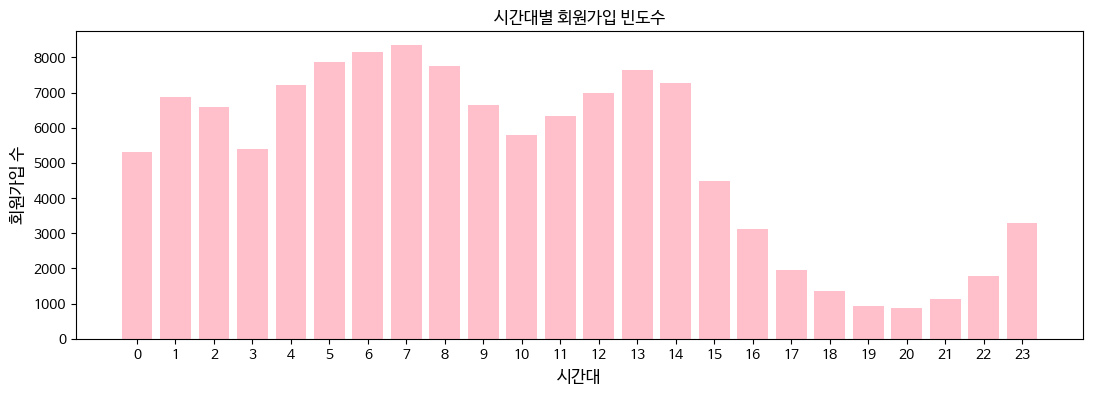

In [ ]:
# 1. 시간대별 회원가입 빈도수 계산
time_grp_counts = signup.groupby('time_grp')[['id']].count()

plt.figure(figsize=(13,4))
plt.bar(time_grp_counts.index, time_grp_counts['id'], color='pink')

plt.title('시간대별 회원가입 빈도수', fontsize=12)
plt.xlabel('시간대', fontsize=12)
plt.ylabel('회원가입 수', fontsize=12)
plt.xticks(time_grp_counts.index)
plt.show()

- 주로 5시~8시의 시간대에 회원가입이 활발했음을 알 수 있다.

In [ ]:
# 2. 월별 시간대별 회원가입 빈도수에 차이가 있는가?
#정규성검정 -> 정규분포를 따른다고 보기 어려우므로, 크루스칼-월리스 검정

import scipy.stats as stats

# 검정할 데이터 준비 (예: 회원가입 빈도수 데이터)
data = signup.groupby('created_month')['id'].count().values

# Shapiro-Wilk 검정 수행
statistic, p_value = stats.shapiro(data)

# 결과 출력
print(f"Shapiro-Wilk 검정 결과: statistic={statistic}, p-value={p_value}")
if p_value > 0.05:
    print("주어진 데이터는 정규 분포를 따르므로, 분산분석을 수행합니다.")
else:
    print("주어진 데이터는 정규 분포를 따르지 않으므로, 크루스칼-윌리스 검정을 수행합니다.")

Shapiro-Wilk 검정 결과: statistic=0.7767682671546936, p-value=0.005161356180906296
주어진 데이터는 정규 분포를 따르지 않으므로, 크루스칼-윌리스 검정을 수행합니다.


In [ ]:
# 월별 시간대별 회원가입 빈도수 집계
pivot_table = signup.pivot_table(index='created_month', columns='time_grp', values='id', aggfunc='count')

# 크루스칼-월리스 검정 수행
statistic, p_value = stats.kruskal(*[group for name, group in pivot_table.items()])

print(f"크루스칼-월리스 검정 결과: statistic={statistic}, p-value={p_value}")
if p_value < 0.05:
    print("월별 시간대별 회원가입 빈도수에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("월별 시간대별 회원가입 빈도수에 통계적으로 유의미한 차이가 없습니다.")

크루스칼-월리스 검정 결과: statistic=238.1162836849965, p-value=1.1307539561193654e-37
월별 시간대별 회원가입 빈도수에는 통계적으로 유의미한 차이가 있습니다.


In [ ]:
#############################  [휴면 고객]  #############################

In [ ]:
user.state.unique()

array(['NORMAL', 'DELETED', 'WITHDRAWN', 'HIBERNATED', 'ZOMBIE'],
      dtype=object)

In [ ]:
user['created_at'] = pd.to_datetime(user['created_at'])
user['last_login_at'] = pd.to_datetime(user['last_login_at'])

#휴면 계정
hibernated = user.loc[user['state']=='HIBERNATED'].reset_index(drop=True)

hibernated['diff_days'] = hibernated['last_login_at'] - hibernated['created_at']
hibernated['diff_days'] = hibernated['diff_days'].apply(lambda x: x.days + (1 if x.seconds / 3600 >= 20 else 0))

aver_use = hibernated['diff_days'].mean().round(0)
no_use = hibernated.loc[hibernated['diff_days']==0]
less1yr_use = hibernated.loc[hibernated['diff_days']<365] #1년 미만 이용 휴면 고객
over1yr_use = hibernated.loc[hibernated['diff_days']>=365] #1년 이상 이용 휴면 고객

print(f'''
전체 휴면 고객 데이터(HIBERNATED)에서 계정 생성일부터 마지막 로그인까지의 기간의 평균은 {aver_use}일 입니다.
하루도 이용하지 않은 휴면 고객은 전체 휴면 고객의 약 {round((no_use.shape[0]/hibernated.shape[0])*100, 1)}%이며,
이용 기간이 1년 미만인 고객은 전체 휴면 고객의 약 {round((less1yr_use.shape[0]/hibernated.shape[0])*100, 1)}%입니다.

이용 기간별 휴면 고객 수를 시각화하면 아래와 같습니다.
''')


전체 휴면 고객 데이터(HIBERNATED)에서 계정 생성일부터 마지막 로그인까지의 기간의 평균은 154.0일 입니다.
하루도 이용하지 않은 휴면 고객은 전체 휴면 고객의 약 29.6%이며,
이용 기간이 1년 미만인 고객은 전체 휴면 고객의 약 84.2%입니다.

이용 기간별 휴면 고객 수를 시각화하면 아래와 같습니다.



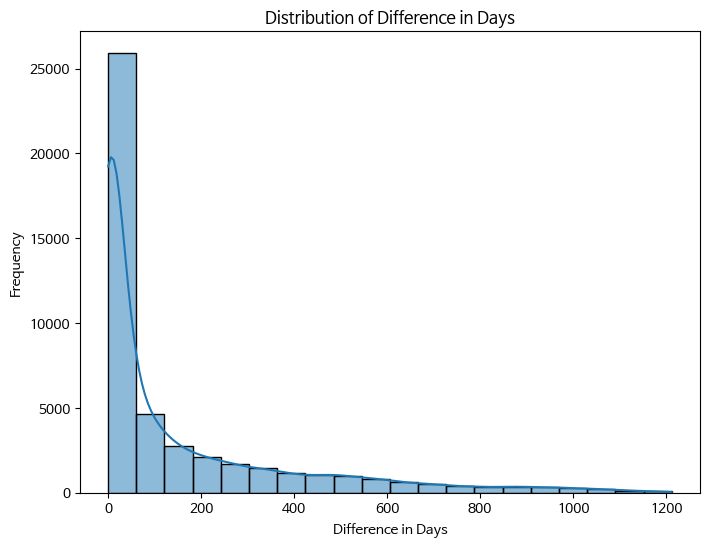

In [ ]:
#이용 기간별 휴면 고객 수 시각화
plt.figure(figsize=(8, 6))
sns.histplot(hibernated['diff_days'], kde=True, bins=20)
plt.title('Distribution of Difference in Days')
plt.xlabel('Difference in Days')
plt.ylabel('Frequency')
plt.show()

- 짧은 이용기간에 치우쳐진 분포가 확인됨.
- 평균은 큰 수의 영향을 많이 받기 때문에, 이용기간에 따른 그룹화 및 평균을 확인하는 것이 적절하다고 판단됨.

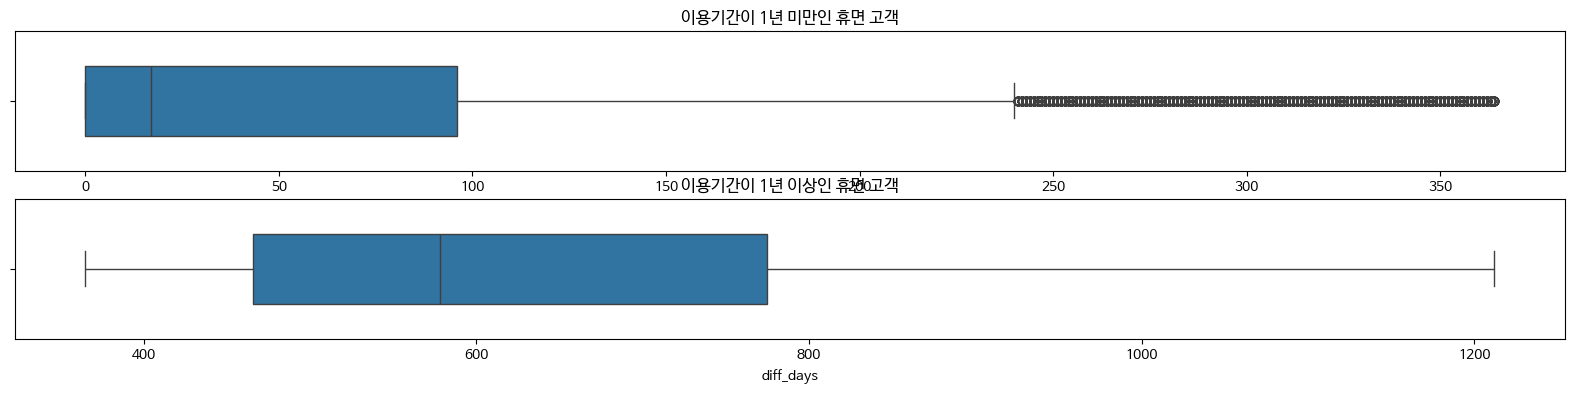

In [ ]:
# 이용기간 1년 이상
plt.figure(figsize=(20,4))

# 첫 번째 박스플롯
plt.subplot(2,1,1)
sns.boxplot(x=less1yr_use['diff_days'], orient='v', width=0.5)
plt.title('이용기간이 1년 미만인 휴면 고객')

# 두 번째 박스플롯
plt.subplot(2,1,2)
sns.boxplot(x=over1yr_use['diff_days'], orient='v', width=0.5)
plt.title('이용기간이 1년 이상인 휴면 고객')

# 그래프 표시
plt.show()

## 2.2 Trend Analysis
각 Dataset(order, course, user, customer and refund)에서
2022년 1월 부터 12월까지의 데이터를 월별로 집계하여 볼 수 있는 트렌드를 하나씩만 보여주세요. Trend를 이용할 때는 어떤 차트를 이용하는 것이 좋을까요?

In [ ]:
order.head(3)

,id,type,state,name,created_at,updated_at,customer_id,list_price,sale_price,discount_price,tax_free_price
0,1600585,ORDER,COMPLETED,[30일 수강] 엑,2022-12-31 23:42:49,2022-12-31 23:42:52,1083679,10000,0,10000,0
1,1600580,ORDER,COMPLETED,한번에 끝내는 재무,2022-12-31 23:39:01,2022-12-31 23:39:25,129176,40000,40000,0,40000
2,1600579,ORDER,COMPLETED,네오아카데미 : 까,2022-12-31 23:38:31,2022-12-31 23:39:17,1072552,20000,10000,10000,10000


In [ ]:
df_list = [order, course, user, customer, refund]
for tmp in df_list:
  tmp['created_at'] = pd.to_datetime(tmp['created_at'])
  tmp['created_ymd'] = tmp['created_at'].dt.date

In [ ]:
customer.head(3)

,id,type,state,created_at,updated_at,user_id,name,phone,email,created_ymd
0,1482394,USER,NORMAL,2024-01-24 04:44:52,2024-01-24 13:54:05,959919,USER_1482394,1012345678,USER_1482394@notexistemail.com,2024-01-24
1,1482300,USER,NORMAL,2024-01-24 04:43:18,2024-01-25 06:10:38,818301,USER_1482300,1012345678,USER_1482300@notexistemail.com,2024-01-24
2,1482071,USER,NORMAL,2024-01-24 04:41:50,2024-01-25 07:46:45,543671,USER_1482071,1012345678,USER_1482071@notexistemail.com,2024-01-24


In [ ]:
customer.state.unique()

array(['NORMAL', 'DELETED', 'WITHDRAWN', 'HIBERNATED'], dtype=object)

In [ ]:
customer['year_month'].min()

Period('2015-02', 'M')

In [ ]:
customer['year'].value_counts()

year
2022    79583
2021    24395
2020    11773
2019     6417
2018      504
2017      163
2016      107
2015       45
2023       23
2024        3
Name: count, dtype: int64

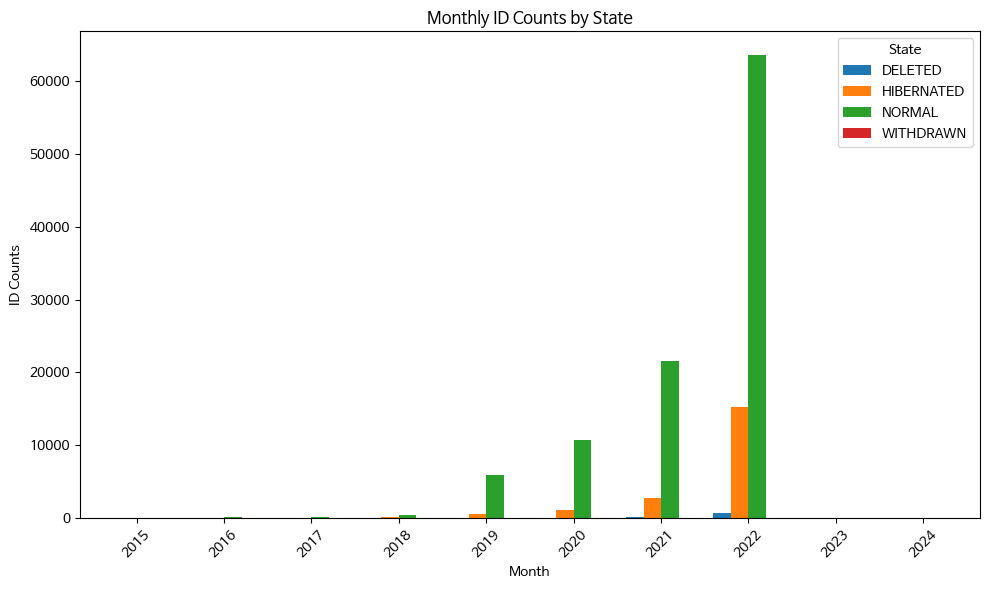

In [ ]:
# 'year_month'라는 새 컬럼에 년월 정보 저장
customer['created_ymd'] = pd.to_datetime(customer['created_ymd'])
customer['year_month'] = customer['created_ymd'].dt.to_period('M')
customer['year'] = customer['created_ymd'].dt.year

# 월별로 state별 id 개수 계산
monthly_state_counts = customer.groupby(['year', 'state']).size().unstack(fill_value=0)

# 시각화
monthly_state_counts.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Monthly ID Counts by State')
plt.xlabel('Month')
plt.ylabel('ID Counts')
plt.xticks(rotation=45)
plt.legend(title='State')
plt.tight_layout()
plt.show()

In [ ]:
customer.id.nunique()

123013

In [ ]:
user.head(3)

,id,type,state,created_at,updated_at,last_login_at,username,created_ymd
0,1075089,USER,NORMAL,2022-12-31 23:39:19,2023-12-02 00:00:22,2022-12-31 23:44:35,dkfk,2022-12-31
1,1075079,USER,NORMAL,2022-12-31 23:08:47,2023-12-03 23:34:39,2023-12-03 23:34:40,toqu,2022-12-31
2,1075074,USER,NORMAL,2022-12-31 22:46:31,2023-10-19 11:49:10,2023-10-19 11:49:10,theh,2022-12-31


In [ ]:
refund.head(3)

,id,type,state,created_at,updated_at,user_id,course_id,amount,tax_free_amount,created_ymd
0,72124,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 07:29:00,2022-12-30 7:29,619833.0,214323.0,-20000,-20000,2022-12-30
1,72121,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 07:01:00,2022-12-30 7:01,146614.0,213905.0,-10000,-10000,2022-12-30
2,72119,ADMIN_AUTO_REFUND,COMPLETED,2022-12-30 06:08:00,2022-12-30 6:08,541404.0,214402.0,0,0,2022-12-30


In [ ]:
course.head(3)

,id,type,state,created_at,updated_at,title,description,close_at,total_class_hours,keywords,created_ymd
0,214903,COURSE,ONGOING,2022-12-27 01:33:00,2022-12-27 1:33,(B2G) K-Di-214903,NaN,NaN,NaN,NaN,2022-12-27
1,214898,COURSE,ONGOING,2022-12-26 12:25:00,2022-12-26 12:25,(B2G) K-Di-214898,NaN,NaN,NaN,NaN,2022-12-26
2,214897,COURSE,ONGOING,2022-12-26 12:20:00,2022-12-26 12:20,(B2G) K-Di-214897,NaN,NaN,NaN,NaN,2022-12-26


# 3. Data Reporting(Dashboard)

In [ ]:
# 1_스트림릿 설치
!pip install -q streamlit

In [ ]:
# 2_스트림릿 화면에 띄울 내용

%%writefile app.py

Writing app.py


In [ ]:
import streamlit as st

# st.write('Hello, *World!* :sunglasses:')
# 해당 내용을 수정해서 사이트를 자유롭게 꾸밀 수 있다.

In [ ]:
# 3
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# "Password/Enpoint IP for localtunnel is:" 우측에 xx.xxx.xx.xxx 혹은 xx.xxx.xxx.xxx 형식의 숫자가 나온다.

Password/Enpoint IP for localtunnel is: 35.202.247.185


In [ ]:
# 4
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.913s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
# 5
!streamlit run app.py &>/content/logs.txt &

In [ ]:
# 6
!npx localtunnel --port 8501

# "your url is:" 우측에 사이트 주소가 생성된다.

npx: installed 22 in 1.472s
your url is: https://short-geese-add.loca.lt
